In [1]:
import gym
# import gym_anytrading

# from stable_baselines3 import A2C
# from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import deque

from Agents.RandomAgent import Random_games
from Env import CustomEnv

In [2]:
df = pd.read_csv('data/BTCUSDT-5m-data.csv').iloc[:10000]

KeyboardInterrupt: 

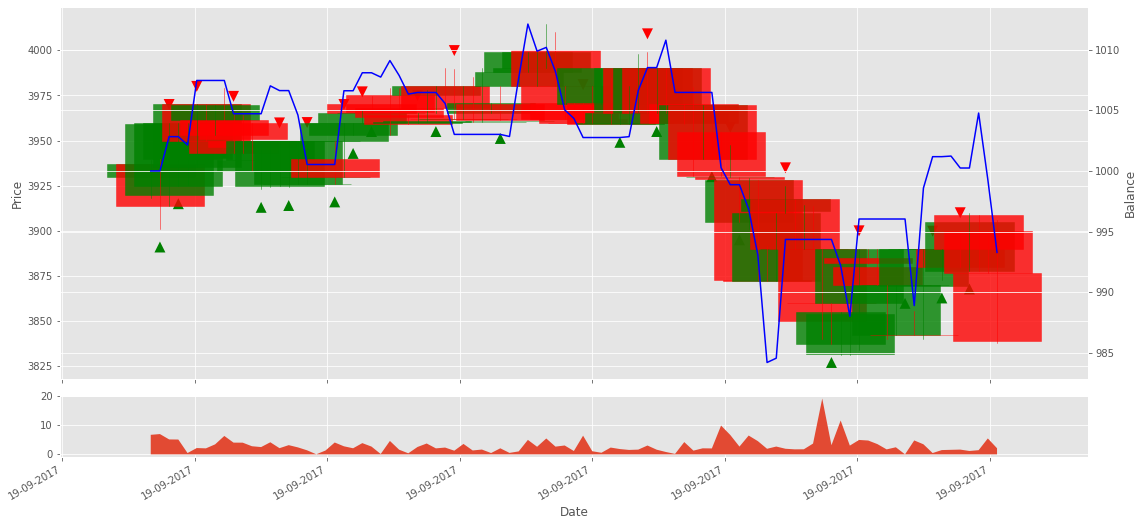

In [3]:
lookback_window_size = 24
train_df = df[:-720-lookback_window_size]
test_df = df[-720-lookback_window_size:] # 30 days

train_env = CustomEnv(train_df, window_size=lookback_window_size)
test_env = CustomEnv(test_df, window_size=lookback_window_size)

Random_games(test_env, visualize=True, train_episodes = 1, training_batch_size=300)

In [3]:
def train_agent(env, visualize=False, train_episodes = 50, training_batch_size=500):
    env.create_writer() # create TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = env.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state
            
        env.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        env.writer.add_scalar('Data/average net_worth', average, episode)
        env.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("net worth {} {:.2f} {:.2f} {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                env.save()

In [4]:
def test_agent(env, visualize=True, test_episodes=10):
    env.load() # load the model
    average_net_worth = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = env.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                print("net_worth:", episode, env.net_worth, env.episode_orders)
                break

AttributeError: 'CustomEnv' object has no attribute 'act'

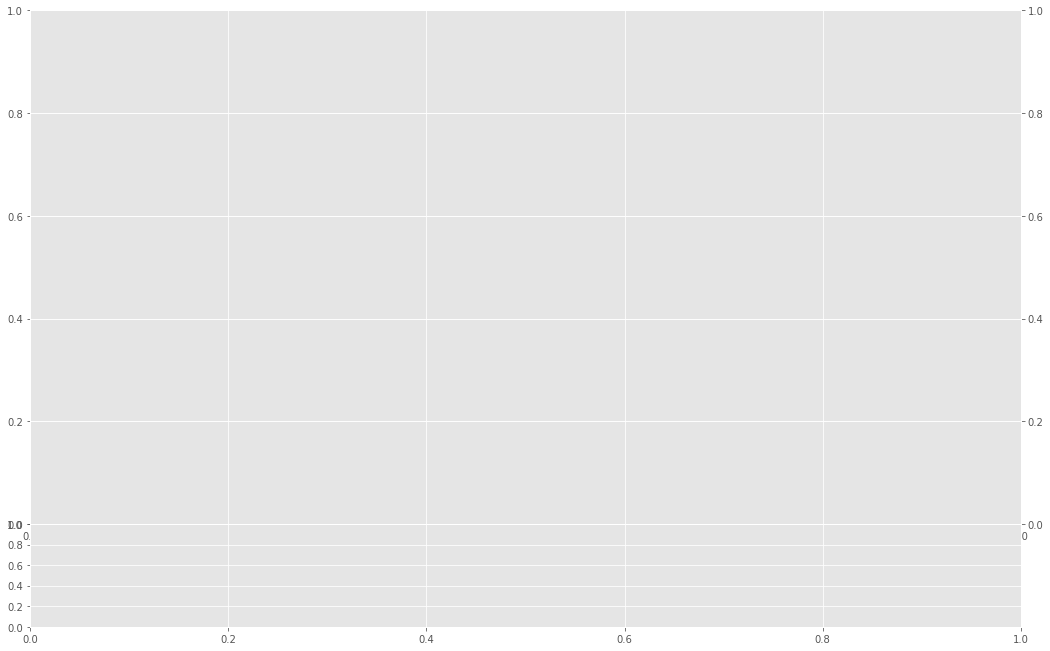

In [6]:
lookback_window_size = 50
train_df = df[:-720-lookback_window_size]
test_df = df[-720-lookback_window_size:] # 30 days

train_env = CustomEnv(train_df, window_size=lookback_window_size)
test_env = CustomEnv(test_df, window_size=lookback_window_size)

train_agent(train_env, visualize=False, train_episodes=20000, training_batch_size=500)
# test_agent(test_env, visualize=True, test_episodes=1000)